In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from numpy.random import default_rng, SeedSequence
import multiprocessing
import concurrent.futures

In [2]:
rng = default_rng()

In [3]:
error = 1e-10 #because machine error is *really* important when working with linalg

In [4]:
def normalize(v):
    l = np.linalg.norm(v)
    if l < error:
        print("Something has gone terribly wrong with "+str(v))
        return v
    return v/l

### Defining shapes
In general we will define a discrete shape to be an array of pairs of points which represent the lines between them.

In [5]:
def polar_poly(r,n):
    r = np.vectorize(r)
    theta = 2*np.pi/n
    angles = np.array([x*theta for x in range(n)])
    p0s = np.vstack((r(angles)*np.cos(angles),r(angles)*np.sin(angles))).T
    p1s = np.array(list(map(lambda i: p0s[(i+1)%n],range(n))))
    return np.array(list(zip(p0s,p1s)))

In [6]:
def ngon(n):
    return polar_poly(lambda t: 1,n)

In [8]:
def circle_arcs(n):
    f = lambda t: np.array([np.cos(t),np.sin(t)])
    fs = []
    ns = []
    tbounds = []
    for i in range(n):
        fs.append(f)
        ns.append(f)
        tbounds.append((2*np.pi/i,2*np.pi/(i+1)))
    return (fs,ns,tbound)

In [9]:
def polar_curve(r,rprime):
    rhat = lambda t: np.array([np.cos(t),np.sin(t)])
    that = lambda t: rhat(t+np.pi/2)
    f = lambda t: r(t)*np.array([np.cos(t),np.sin(t)])
    n = lambda t: -r(t)*rhat(t)+rprime(t)*that(t)
    tbound = (0,2*np.pi)
    return ([f],[n],[tbound])

General Hit Algorithms

In [10]:
def line_hit(x,v,p0,p1):
    dp = p0-p1#np.subtract(p0,p1)
    a = np.vstack((v,dp)).T
    b = p0-x#np.subtract(p0,x)
    t = np.linalg.solve(a,b)
    nx = x+t[0]*v #np.add(x,np.multiply(t[1],v))
    p = p0-t[1]*dp#np.add(p0,np.multiply(t[0],dp))
    if t[1] < 1 and t[1] > 0 and t[0] > 0 and np.linalg.norm(p-nx) < error:
        n = np.array([-dp[1],dp[0]])
        return True, (p,n,(x,v,t[0]))
    else:
        return False, ()

In [11]:
def curve_hit(x,v,f,n,tbound):
    g = lambda st: (x+v*st[0])-f(st[1])
    hit,_,_,i,m = fsolve[f,[1,0.5*tbound[0]+0.5*tbound[1]]]
    if i == 1:
        r = normalize(n(hit[1]))
        p = x+v*hit[0]
        return True, (p,r,(x,v,st[1]))
    return False, ()

Filtering specific hits of piecewise curves/shapes

In [12]:
def general_hit(hits):
    crossings = list(map(lambda x: (x[1],x[2]), filter(lambda x: x[0], hits)))
    if crossings == []:
        print('oh no')
        print(hits)
    cross = sorted(crossings,key=lambda x: x[0][2][2])[0]
    p = cross[0][0]
    n = cross[0][1]
    s = cross[1]
    return p, n, s

In [13]:
def polygon_hit(ps):
    def hit(x,v):
        hits = list(map(lambda p: line_hit(x,v,*p[1])+(p[0],),enumerate(ps))) #append i to the side
        return general_hit(hits)
    return hit

In [14]:
def piecewise_smooth(fs,ns,tbounds):
    def hit(x,v):
        hits = list(map(lambda ifnt: curve_hit(x,v,ifnt[1],ifnt[2],ifnt[3])+(ifnt[0],),enumerate(zip(fs,ns,tbounds))))
        return general_hit(hits)
    return hit

Special Cases

In [15]:
def circle_hit(x,v):
    b = np.dot(v,x)
    c = np.linalg.norm(x)**2 -1
    ts = -b+np.array([1,-1])*np.sqrt(b**2 - c)
    t = np.min(ts[np.all(np.greater(ts,[0,0]))])
    p = x+t*v
    n = -p
    return p, n, np.arctan2(x[1],x[0])

Bounce algorithm

In [16]:
def bounce(v,n):
    n = normalize(n)
    return v-2*np.dot(n,v)*n#np.subtract(v,np.multiply(2*np.dot(n,v),n))

Simulation of many bounces

In [17]:
def sim(hitFunc,x,v,depth):
    lines = [(x,v,-1)]
    for _ in range(depth):
        x, n, s = hitFunc(x,v)
        v = bounce(v,n)
        x = x+error*v#np.add(x,np.multiply(1e-12,v))
        lines = lines + [(x,v,s)]
    return lines

Random Start Info

In [18]:
def randx(rad):
    r = rng.random()*rad
    theta = 2*np.pi*rng.random()
    x = np.multiply(r,np.array([np.cos(theta),np.sin(theta)]))
    return x
def randv():
    vtheta = 2*np.pi*rng.random()
    v = np.array([np.cos(vtheta),np.sin(vtheta)])
    return v

Get data for plotting

In [19]:
def side_chance(sim_result,mod=0):
    if mod == 0:
        s = np.array(list(map(lambda x: x[2],sim_result[1:])))
    else:
        s = np.array(list(map(lambda x: x[2]%mod,sim_result[1:])))
    uniques = np.unique(s)
    counts = np.array(list(map(lambda u: sum(1 for side in s if side == u),uniques)))
    counts = normalize(counts)
    return uniques,counts

Specific Square Sims

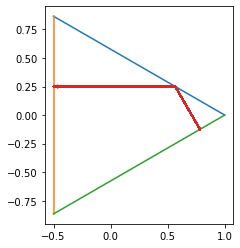

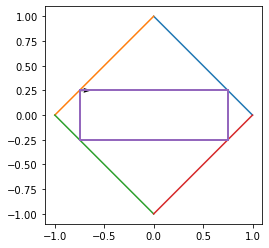

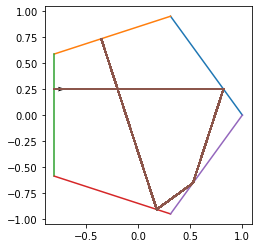

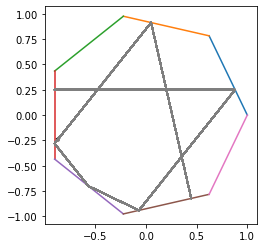

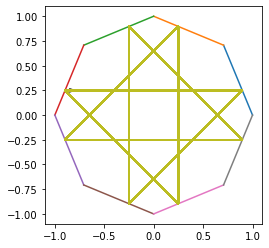

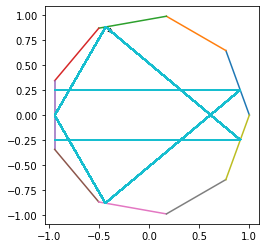

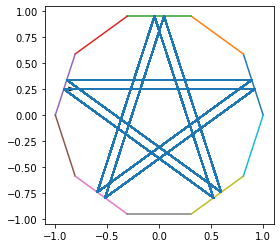

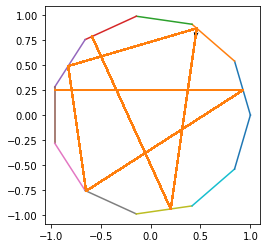

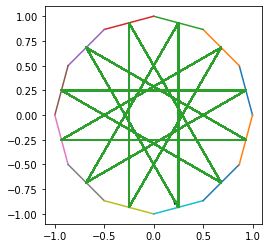

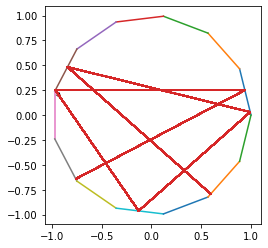

LinAlgError: Singular matrix

In [71]:
for i in range(17):
    n = i+3#2*(i+1)+1
    if n == 6:
        continue
    sq = ngon(n)
    sqhit = polygon_hit(sq)
    ls = sim(sqhit,np.array([0,0.25]),np.array([1,0]),1000)
    plt.plot(*sq.T)
    xs = list(map(lambda x: x[0][0], ls))
    ys = list(map(lambda x: x[0][1], ls))
    plt.plot(xs,ys)
    x,v,_ = ls[-1]
    plt.quiver(*x,*v)
    ax = plt.gca()
    ax.set_aspect(1)
    plt.savefig('{}gonorbit.png'.format(n))
    plt.show()

<BarContainer object of 2 artists>

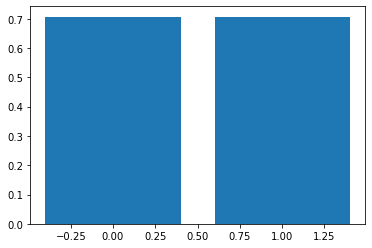

In [21]:
ss = list(map(lambda x: x[2]%2,ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=2*sides)
us,cs = side_chance(ls,mod=2)
plt.bar(us,cs)

Specifically Circular Sims

(array([-0.8660254, -0.5      ]), array([-1.00000000e+00, -2.34631758e-10]), 1.57079632697881)


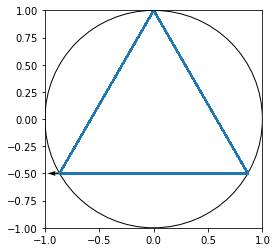

In [22]:
deg = 30
theta = np.pi/2-(np.pi/180)*deg #<- Edit this!
ls = sim(circle_hit,np.array([0,1]),np.array([np.cos(theta),np.sin(theta)]),1000)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
#print(xs)
plt.plot(xs,ys)
print(ls[-1])
x,v,_ = ls[-1]
plt.quiver(*x,*v)
draw_circle = plt.Circle((0, 0), 1,fill=False)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gcf().gca().add_artist(draw_circle)
plt.gca().set_aspect(1)
plt.savefig("{}deg.png".format(deg))
plt.show()

<BarContainer object of 1000 artists>

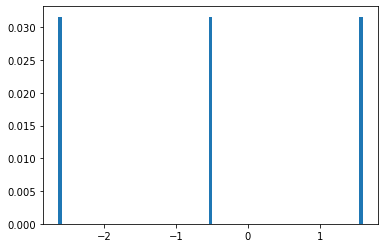

In [23]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss) #<- Side sequence
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
us,cs = side_chance(ls)
plt.bar(us,cs,width=0.05)

Discrete Cardiod Sims

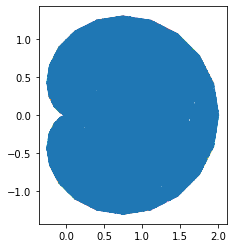

In [24]:
shape = polar_poly(lambda t: 1+np.cos(t),30)
shapehit = polygon_hit(shape)
ls = sim(shapehit,randx(0.5)+np.array([0.75,0]),randv(),1000)
plt.plot(*shape.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('cardiod.png')
plt.show()

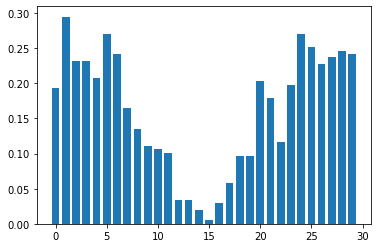

In [25]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
sidelengths = np.array(list(map(lambda q: np.linalg.norm(q[1]-q[0]),shape)))
us,cs = side_chance(ls)
ncs = cs/sidelengths[us]
plt.bar(us,cs,width=0.75)
plt.savefig("normalizedcardiodsidesplot.png")

Setting up shapes etc.

In [68]:
sides = 6
bounces = 50
ng = ngon(sides)
nghit = polygon_hit(ng)

Random Circle & N-Gon

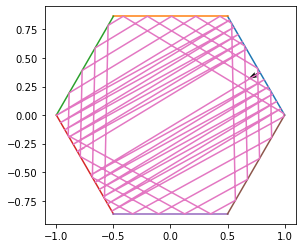

In [70]:
ls = sim(nghit,randx(np.cos(np.pi/sides)),randv(),bounces)
plt.plot(*ng.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('ngonirrational2.png')
plt.show()

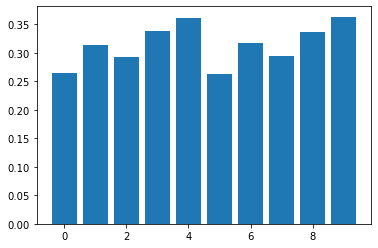

In [28]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=2*sides)
us,cs = side_chance(ls)
plt.bar(us,cs)
plt.savefig('100.png')

(array([-0.59658354,  0.80255098]), array([-0.41186982,  0.9112427 ]), -0.502094414447757)


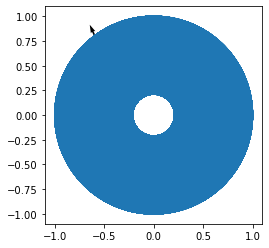

In [29]:
ls = sim(circle_hit,randx(0.9),randv(),bounces)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
print(ls[-1])
x,v,_ = ls[-1]
plt.quiver(*x,*v)
draw_circle = plt.Circle((0, 0), 1,fill=False)
plt.gcf().gca().add_artist(draw_circle)
plt.gca().set_aspect(1)
plt.show()

<BarContainer object of 10000 artists>

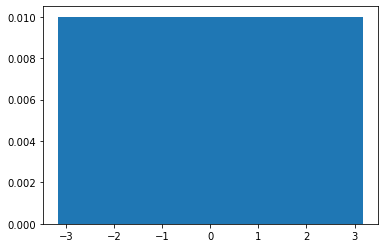

In [30]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
us,cs = side_chance(ls)
plt.bar(us,cs,width=0.05)